#### median_house_value is the field we want to predict.

In [82]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
%matplotlib inline

In [83]:
housing_df = pd.read_csv('house_price.csv')

housing_df.columns = housing_df.columns.str.strip()
housing_df = housing_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# 2347
# because we work with xgboost later, we need to change <1h ocean value to 1h ocean, < is not a valid character for xgboost
housing_df['ocean_proximity'] = housing_df['ocean_proximity'].replace('<1H OCEAN', '1H OCEAN')

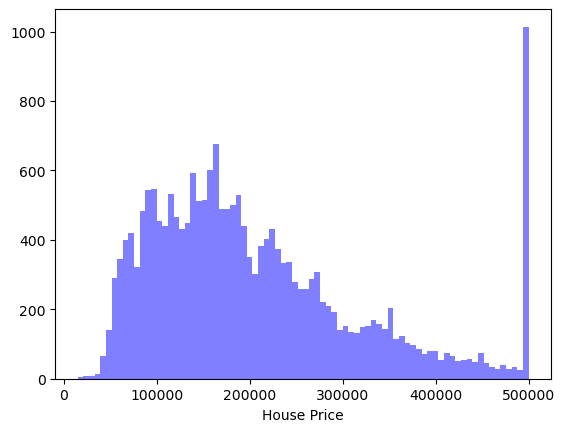

In [85]:
plt.hist(housing_df['median_house_value'], bins=80, color='blue', alpha=0.5)
# bins: number of bars
# alpha: transparency of the bars
plt.xlabel('House Price')
plt.show()

In [86]:
# outliers meaning distribution is not normal, it is not similar to others.
# outliers can effect the accuracy of the model.

### Deal with missing values

Ways to deal with missing values:
1. Drop the rows with missing values
2. Drop the columns with missing values
3. Fill the missing values with a specific value (e.g. mean, median, mode)
4. Use machine learning algorithms to predict the missing values
5. Use machine learning algorithms that can handle missing values gracefully (e.g. XGBoost, LightGBM, CatBoost)

In [87]:
# use knn (k-nearest neighbors) to fill the missing values in small dataset.
# knn is a supervised machine learning algorithm that can be used for classification and regression.
# It works by finding the k nearest neighbors to a data point and using their values to predict the value of the data point.
# basically meaning identifies a sample with one or more missing values then finds the most similar samples that are complete, then uses the values of those samples to fill in the missing values.
# It is a lazy learning algorithm, meaning it does not learn a model from the training data, but instead stores the training data and uses it to make predictions.

In [88]:
housing_df.isnull().sum() # check for missing values in each column

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [89]:
from sklearn.impute import KNNImputer
housing_df_copy = housing_df.copy()

# columns = housing_df_copy.columns.tolist()
# columns = columns[columns != 'ocean_proximity']
columns = [col for col in housing_df_copy.columns if housing_df_copy[col].dtype != 'object'] # get all columns except ocean_proximity
missing_columns = [col for col in columns if housing_df_copy[col].isnull().sum() > 0] # get columns with missing values
# missing_columns = [col for col in housing_df_copy.loc[:, housing_df_copy.isnull().any()]]

housing_df_missing = housing_df_copy[missing_columns] # create a new dataframe with only the columns with missing values

In [90]:
imputer = KNNImputer(n_neighbors=3) # n_neighbors is the number of neighbors to use for imputation
# should try different values for n_neighbors to see which one works best.
imputer.fit(housing_df_missing) # fit the imputer to the data
housing_df_imputed = imputer.transform(housing_df_missing) # transform the data
housing_df_copy = pd.DataFrame(housing_df_imputed, columns=missing_columns)

In [91]:
housing_df_copy.isnull().sum() # check if there are any missing values left

total_bedrooms    0
dtype: int64

In [92]:
# overlay the imputed column over the old column with missing values

# loop through the list of columns and overlay each one
for column_name in missing_columns:
    housing_df[column_name] = housing_df_copy.replace(housing_df[column_name],housing_df[column_name])

housing_df.isnull().sum() # confirm columns no longer contain null data

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Encoding Categorical Values

In [93]:
housing_df.ocean_proximity.unique()
housing_df.ocean_proximity.value_counts()

ocean_proximity
1H OCEAN      9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [94]:
# one hot encoding: convert categorical features into numerical features.
# pd.get_dummies(housing_df.ocean_proximity)
# it basically creates a new column for each category in the categorical feature and assigns a 1 or 0 to each row depending on whether it belongs to that category or not.
# print(pd.get_dummies(housing_df.ocean_proximity)) # drop_first=True to avoid dummy variable trap (multicollinearity)
print(pd.get_dummies(housing_df['ocean_proximity']))

       1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0         False   False   False      True       False
1         False   False   False      True       False
2         False   False   False      True       False
3         False   False   False      True       False
4         False   False   False      True       False
...         ...     ...     ...       ...         ...
20635     False    True   False     False       False
20636     False    True   False     False       False
20637     False    True   False     False       False
20638     False    True   False     False       False
20639     False    True   False     False       False

[20640 rows x 5 columns]


In [95]:
housing_df_encoded = pd.get_dummies(housing_df, columns=['ocean_proximity'])
housing_df_encoded.head() # now we have 5 columns instead of 1 column for ocean_proximity.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


Now we work with housing_df_encoded 

### Correlation Analysis and Dealing with High Correlation

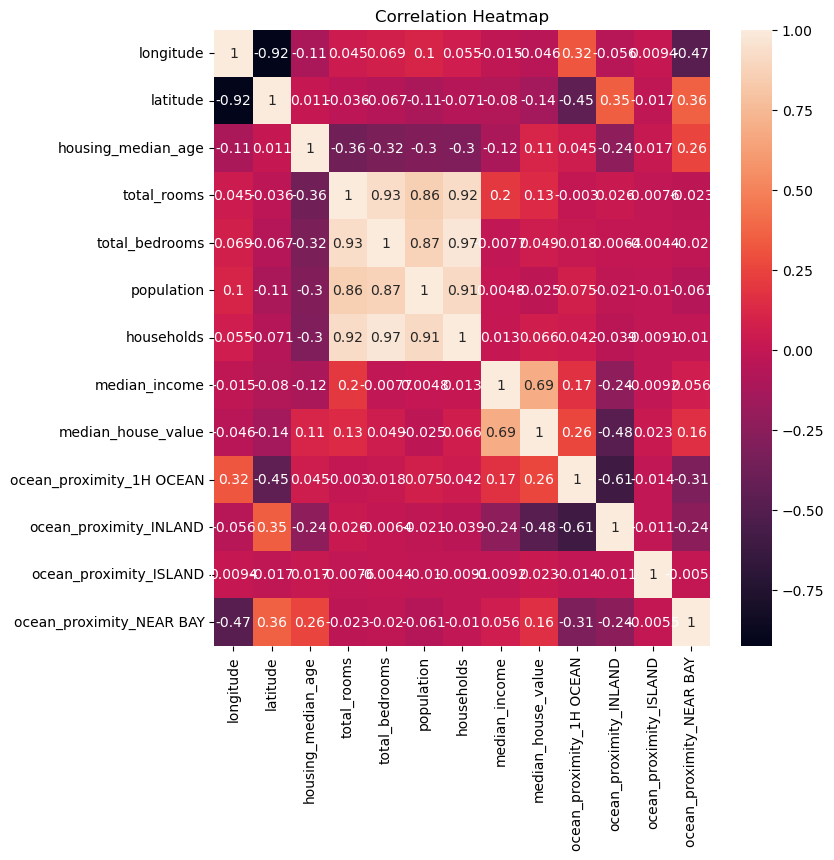

In [96]:
# use heatmap to visualize the correlation between features
# correlation means how much one feature is related to another feature.
# housing_df_encoded.iloc[:, :-1].corr() # : all rows, :-1 all columns except the last one
plt.figure(figsize=(8, 8)) # size of the figure
sns.heatmap(housing_df_encoded.iloc[:, :-1].corr(), annot=True) # annot=True to show the correlation values in the heatmap
plt.title('Correlation Heatmap')
plt.show()

In [97]:
# If features are highly correlated: those features could possibly teach the model the same thing. 
# Highly correlated features can cause the model to overfit.
# Overfitting means the model is too complex and learns the noise in the data instead of the signal -> it performs well on the training data but poorly on the test data.
# highly correlated features can be removed or combined into one feature.

1 indicates a perfect positive correlation: as one variable increases, the other variable also increases.

-1 indicates a perfect negative correlation: as one variable increases, the other variable decreases.

0 indicates no correlation: the two variables are not related to each other.

In [98]:
# we can use ratios of features to create new features.
housing_df_encoded['rooms_per_household'] = housing_df_encoded['total_rooms'] / housing_df_encoded['households']
housing_df_encoded['bedrooms_per_room'] = housing_df_encoded['total_bedrooms'] / housing_df_encoded['total_rooms']
housing_df_encoded['population_per_household'] = housing_df_encoded['population'] / housing_df_encoded['households']
housing_df_encoded['coords'] = housing_df_encoded['longitude'] / housing_df_encoded['latitude']

# drop the original features
housing_df_encoded = housing_df_encoded.drop(['total_rooms', 'total_bedrooms', 'population', 'households', 'longitude', 'latitude'], axis=1)

#### New heatmap with new features

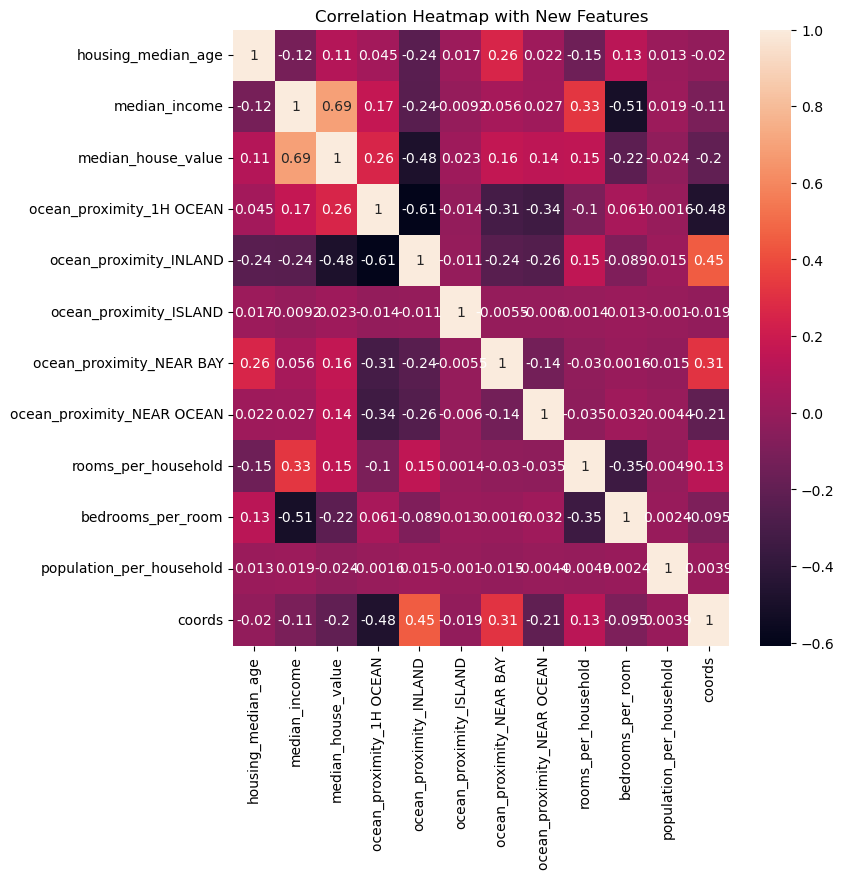

In [99]:
plt.figure(figsize=(8, 8))
sns.heatmap(housing_df_encoded.iloc[:, housing_df_encoded.columns != 'ocean_proximity'].corr(), annot=True)
plt.title('Correlation Heatmap with New Features')
plt.show()

### It's training time!

- During training process, the machine makes multiple passes (iterations) over the data, each time adjusting the model parameters to minimize the error -> epochs.
- The number of epochs is the number of times the model will see the entire training data.
- Too much epochs can cause overfitting, too little epochs can cause underfitting.

Loss function: measure of how far the predicted values are from the actual values.

Some evaluation metrics:
1. Mean Absolute Error (MAE): the average of the absolute differences between the predicted and actual values.
2. Mean Squared Error (MSE): the average of the squared differences between the predicted and actual values.
3. Root Mean Squared Error (RMSE): the square root of the MSE.
4. R-squared: the proportion of the variance in the dependent variable that is predictable from the independent variables.
5. Adjusted R-squared: the R-squared value adjusted for the number of predictors in the model.
6. F1 score: the harmonic mean of precision and recall.
7. Precision: the number of true positives divided by the number of true positives plus the number of false positives.
8. Recall: the number of true positives divided by the number of true positives plus the number of false negatives.
9. Accuracy: the number of correct predictions divided by the total number of predictions.
10. Confusion matrix: a table that is often used to describe the performance of a classification model.
11. ROC curve: a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
12. AUC: the area under the ROC curve.

3 commonly used algorithms for regression:
1. Linear regression
2. Decision tree regression / Random forest regression 
3. XGBoost

- Logistic regression is a linear model for binary classification. It is used to predict the probability of a binary outcome (0 or 1) based on one or more predictor variables.
- Decision tree is both a classification and regression algorithm. The tree depth can be controlled by setting the max_depth parameter.
- Random forest is an ensemble of decision trees. It is used to improve the accuracy of the model by combining the predictions of multiple decision trees. Each tree is trained on a random subset of the data and the final prediction is made by averaging the predictions of all the trees.

Split the data into training and testing sets

In [100]:
from sklearn.model_selection import train_test_split

X = housing_df_encoded.drop('median_house_value', axis=1) # features
y = housing_df_encoded['median_house_value'] # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) # 80% for training and 20% for testing
# random_state is used to seed the random number generator, so that the results are reproducible.

In [101]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # check the shape of the data

(16512, 11) (4128, 11) (16512,) (4128,)


# Sklearn's Linear Regression

In [102]:
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(X_train, y_train) # fit the model to the training data

LinearRegression()

In [103]:
y_pred_reg = reg_model.predict(X_test) # predict the target variable for the test data

In [104]:
# evaluate the model
pred_test_df = pd.DataFrame({'Actual (y_test): ': y_test, 'Predict (y_pred): ': y_pred_reg})
pred_test_df

,Actual (y_test):,Predict (y_pred):
20046,47700.0,104345.336280
3024,45800.0,90820.369998
15663,500001.0,215776.068599
20484,218600.0,283354.319517
9814,278000.0,245168.827947
...,...,...
15362,263300.0,225962.941236
16623,266800.0,188144.855757
18086,500001.0,434404.617285
2144,72300.0,110239.173719


In [105]:
from sklearn.metrics import r2_score

r2 = round(reg_model.score(X_test, y_test), 2)
r_2 = r2_score(y_test, y_pred_reg)
print(f'R^2 score: {r2}') # the closer to 1, the better the model is performing.
print(f'R^2 score using r2_score: {r_2}') # should be the same as r2, or at least very close.

R^2 score: 0.52
R^2 score using r2_score: 0.5151779395512528


### Save and use the model

In [ ]:
import joblib
joblib.dump(reg_model, 'reg_model.pkl') # Save model
loaded_model = joblib.load('reg_model.pkl') # Load model to make predictions

# Random Forest Regressor

In [106]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=10, random_state=10) # n_estimators is the number of trees in the forest
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=10)

In [107]:
y_pred_rf = rf_model.predict(X_test) # predict the target variable for the test data

In [108]:
# evaluate the model
rf_pred_test_df = pd.DataFrame({'Actual (y_test): ': y_test, 'Predict (y_pred): ': y_pred_rf})
rf_pred_test_df

,Actual (y_test):,Predict (y_pred):
20046,47700.0,47330.0
3024,45800.0,82830.0
15663,500001.0,382810.1
20484,218600.0,279290.0
9814,278000.0,217970.0
...,...,...
15362,263300.0,229240.0
16623,266800.0,234270.0
18086,500001.0,487820.8
2144,72300.0,73560.0


In [109]:
r2_rf = r2_score(y_test, y_pred_rf)
print(f'R^2 score: {r2_rf}')

R^2 score: 0.754331291308119


# XGBoost

In [110]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [111]:
y_pred_xgb = xgb_model.predict(X_test) # predict the target variable for the test data
# evaluate the model
xgb_pred_test_df = pd.DataFrame({'Actual (y_test): ': y_test, 'Predict (y_pred): ': y_pred_xgb})
xgb_pred_test_df


,Actual (y_test):,Predict (y_pred):
20046,47700.0,47042.636719
3024,45800.0,94094.601562
15663,500001.0,425418.531250
20484,218600.0,270771.906250
9814,278000.0,243807.562500
...,...,...
15362,263300.0,277294.312500
16623,266800.0,224339.906250
18086,500001.0,499030.906250
2144,72300.0,72494.328125


In [112]:
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'R^2 score: {r2_xgb}')

R^2 score: 0.7731935169881191


Clustering: unsupervised learning
Kmeans: group similar data points together. It works by finding the centroids of the clusters and assigning each data point to the nearest centroid.
It is sensitive to the initial placement of the centroids, so it is recommended to run the algorithm multiple times with different initializations and choose the best one.
Kmeans output is a set of clusters, each with a centroid and a set of data points assigned to that centroid.
The number of clusters is k (hyperparameter).
Experiment with different values or use elbow method.

Text classification is a common unsupervised learning task.

We have been training models with default values, haven't change anything (hyperparameters)

In [113]:
xgb_model.get_params() # get the parameters of the model

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

- Different metrics help to evaluate the model performance in different ways.
- Metrics help you shape the output the way you want it to be.

Regression metrics:
1. Mean Absolute Error (MAE): the average of the absolute differences between the predicted and actual values.
3. Root Mean Squared Error (RMSE): the square root of the MSE.
5. R-squared: the proportion of the variance in the dependent variable that is predictable from the independent variables.
2. Mean Squared Error (MSE): the average of the squared differences between the predicted and actual values.

### Feature importance

- Improves prediction
- Reduces training time and cost
- Selects important features

Algorithms with embedded feature selection:
- tree-based models from sklearn (e.g. Random Forest, Decision Tree, XGBoost, LightGBM, CatBoost)
- random forest
- gradient boost

### Bias

It shows up in: dataset, algorithm, and model.
- Dataset: imbalanced, missing values, noise,...
- Algorithm: wrong choice of algorithm, hyperparameters, features, evaluation metric, training data, test data, validation data, cross-validation method.
- Model: overfitting, underfitting.

# Pipeline

In [114]:
from sklearn.pipeline import Pipeline

pipeline_lg = Pipeline([('lr_classifier', LinearRegression())])
pipeline_rf = Pipeline([('lr_classifier', RandomForestRegressor(n_estimators=10, random_state=10))])
pipeline_xgb = Pipeline([('lr_classifier', XGBRegressor())])

pipelines = [pipeline_lg, pipeline_rf, pipeline_xgb]
pipe_dict = {0: 'Linear Regression', 1: 'Random Forest', 2: 'XGBoost'}

for pipe in pipelines:
    pipe.fit(X_train, y_train) # fit the model to the training data
    y_pred = pipe.predict(X_test) # predict the target variable for the test data
    r2 = r2_score(y_test, y_pred) # calculate the r2 score
    print(f'{pipe_dict[pipelines.index(pipe)]} R^2 score: {r2}') # print the r2 score for each model

for i, model in enumerate(pipelines):
    pred_test = model.predict(X_test)
    print('{} Test accuracy: {}', format(pipe_dict[i], model.score(X_test, y_test)))
    print(pd.DataFrame({'Actual (y_test): ': y_test, 'Predict (y_pred): ': pred_test}))



Linear Regression R^2 score: 0.5151779395512528
Random Forest R^2 score: 0.754331291308119


AttributeError: 'super' object has no attribute '__sklearn_tags__'